In [ ]:
#!git clone https://github.com/Andrew2077/DDPM.git
# import sys
# sys.path.insert(0,"/content/DDPM")

fatal: destination path 'DDPM' already exists and is not an empty directory.


In [1]:
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
from DDUN.UNET import *
from DDUN.DataPrep import *
from DDUN.Forward import *
from DDUN.Loss import get_loss
import warnings
warnings.filterwarnings("ignore")

T = 50
START = 1e-4
END = 1e-2

model = Diffusion_Unet()
batch_size = 32
dataloader = Fashion_Mnist_loader(data_path="data", batch_size=batch_size, shuff=True, drop_last=True)
sample = next(iter(dataloader))[0]
sample.shape

torch.Size([32, 1, 28, 28])

In [10]:
# dataloader = Fashion_Mnist_loader(data_path="data", batch_size=batch_size, shuff=True, drop_last=True)
# #* split data into train and test

data = datasets.FashionMNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
Sample, train_data = torch.utils.data.random_split(data, [256, len(data) - 256])
input_transformation = transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: (x * 2) - 1)]
    )

sample_loader = DataLoader(
        Sample,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )

len(sample_loader)

8

In [13]:
betas = intiate_betas(T, START, END)
alphas_cumprod = calc_cumprod_alphas(betas)
alphas_cumprod_prev = clac_cumoprod_alphas_prev(betas)

sqrt_recip_alphas = calc_sqrt_recip_alpha(betas)
sqrt_alphas_cumpord = calc_sqrt_cumprod_alphas(betas)
sqrt_one_minus_alphas_cumpord = calc_sqrt_one_minus_cumpord_alphas(betas)

postierior_variance = calc_postierior_variance(betas)

In [14]:
defused_sample = Forward_pass(
    sample,
    torch.randint(0, T, (batch_size,)),
    sqrt_alphas_cumpord,
    sqrt_one_minus_alphas_cumpord,
    device="cpu",
    torch_seed=42,
)

t = torch.randint(0, T, (batch_size,))
prediction = model(sample, t)




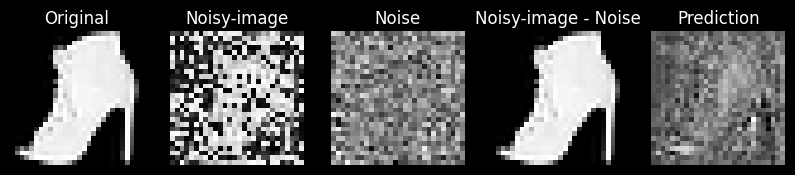

In [15]:
image = sample[0][0]
noisy_img = defused_sample[0][0][0]
noise = defused_sample[1][0][0]
prediction_image = prediction[0][0]

plt.figure(figsize=(10, 10))
plt.subplot(1, 5, 1)
plt.title('Original')
plt.axis('off')
plt.imshow(prep_imshow(image), cmap="gray")

plt.subplot(1, 5, 2)
plt.title('Noisy-image')
plt.axis('off')
plt.imshow(prep_imshow(noisy_img), cmap="gray")

plt.subplot(1, 5, 3)
plt.title('Noise')
plt.axis('off')
plt.imshow(prep_imshow(noise), cmap="gray")

plt.subplot(1, 5, 4)
plt.title('Noisy-image - Noise')
plt.axis('off')
plt.imshow(prep_imshow(noisy_img- noise), cmap="gray")

plt.subplot(1, 5, 5)
plt.title('Prediction')
plt.axis('off')
plt.imshow(prep_imshow(prediction_image.detach()), cmap="gray")


#### Model mean :

$$
\mu = \sqrt{\bar{\alpha_t}} *(x - \beta_t \frac{P_{model}(x,t)}{\sqrt{1-\alpha_t}} )
$$


#### Model variance :

- posterior variance at time t

$$
\sigma_{posterior} = \beta * \frac{1 - \alpha_{comprod-previous}}{1- \alpha_{cumprod}}
$$



In [16]:
@torch.no_grad()
def Sample_timestep(x, t):
    # * get beta at time t
    beta_t = get_index_from_list(betas, t, x.shape)

    # * get sqrt of alphas cumpord at time t
    sqrt_one_minus_alphas_cumpord_t = get_index_from_list(
        sqrt_one_minus_alphas_cumpord, t, x.shape
    )

    # * get sqrt of reciprocal alphas at time t
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # * model mean
    model_mean = sqrt_recip_alphas_t * (x - beta_t * model(x, t) / sqrt_one_minus_alphas_cumpord_t)
    
    #* model variance : postierior variance fixed variance at time t
    model_variance = get_index_from_list(postierior_variance, t, x.shape)
    
    if t == 0:
        return model_mean # model_variance = 0, at t = 0
    
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(model_variance) * noise
    


In [36]:
@torch.no_grad()
def sample_plot_image(device):
    image_size = 28
    img = torch.randn((1, 1, image_size, image_size), device=device)
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    num_images = 10
    step_size = int(T / num_images)
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, dtype=torch.long, device=device)
        # t = torch.tensor([i], device=device)
        img = Sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % step_size == 0:
            plt.subplot(1, num_images, int(i / step_size) + 1)
            plt.axis("off")
            plt.imshow(prep_imshow(img[0][0].cpu()), cmap="gray")
            plt.title(f"t = {i}")
    plt.show()

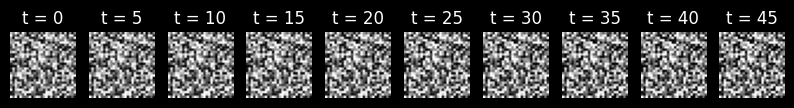

In [37]:
sample_plot_image("cuda")

## Training

In [18]:
from torch.optim import Adam
from tqdm.notebook import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
epochs = 100


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:  0 Step:  7


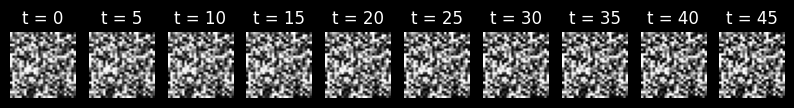

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:  2 Step:  7


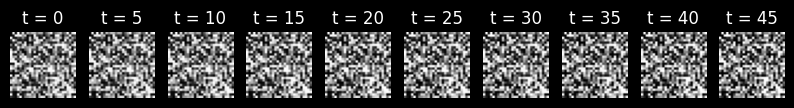

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:  4 Step:  7


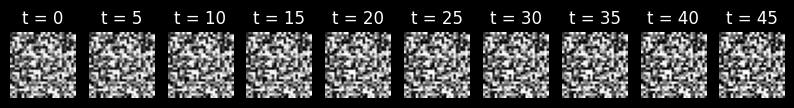

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:  6 Step:  7


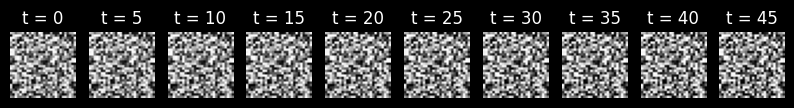

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:  8 Step:  7


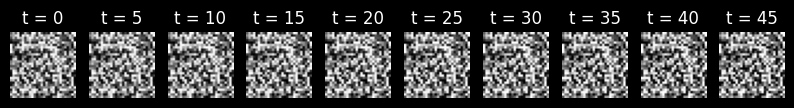

  0%|          | 0/8 [00:00<?, ?it/s]

In [38]:
epochs = 10
for epoch in range(epochs):
    for step, (x, _) in enumerate(tqdm(sample_loader)):
        # print(step)
        if (epoch % 2 == 0 ) and (step == len(sample_loader)-1):
            print("Epoch: ", epoch, "Step: ", step)
            sample_plot_image(device)

In [ ]:
for epoch in range(epochs):
    for step, (x, _) in enumerate(tqdm(sample_loader)):
        optimizer.zero_grad()

In [45]:
sample[0][0]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9765, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.7333, -0.2549,  0.0745,  0.3333,  0.3804,  0.6471,  0.2784, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9608, -0.9059, -1.0000, -1.0000, -1.0000, -0.3725,  0.7333,
          1.0000,  1.0000,  0.9843,  0.9608,  0.8588,  0.9137,  0.8353, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -0.9137,  0.7725,  0.9529,  0.9608,
          0.8745,  0.7961,  0.8118,  0.8118,  0.7490,  0.8510,  0.9608, -1.0000,
         -1.0000, -0.9922, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9922, -1.0000, -0.9765,
         -1.0000, -0.5529, -0.1529, -0.5608,  1.0000

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0, Step: 0, Loss: 0.11754068732261658


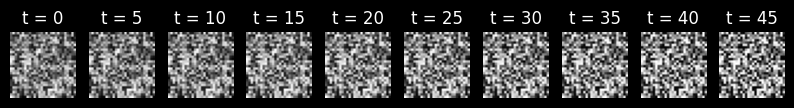

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1, Step: 0, Loss: 0.08951549232006073


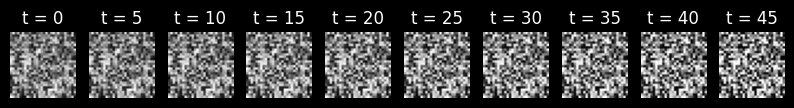

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 2, Step: 0, Loss: 0.07633166015148163


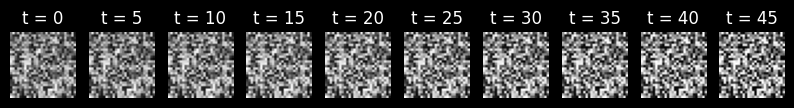

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 3, Step: 0, Loss: 0.06735403835773468


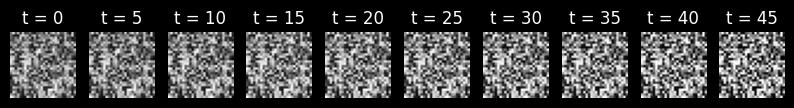

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 4, Step: 0, Loss: 0.06126275286078453


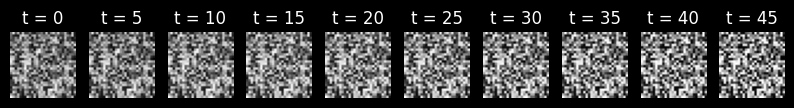

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 5, Step: 0, Loss: 0.055971644818782806


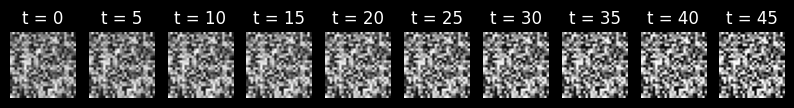

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 6, Step: 0, Loss: 0.05201178416609764


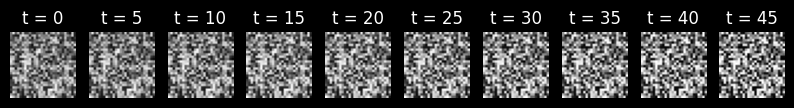

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 7, Step: 0, Loss: 0.051009129732847214


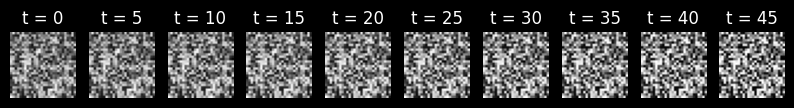

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 8, Step: 0, Loss: 0.05101046711206436


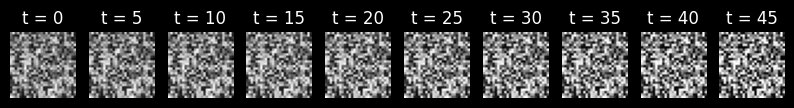

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 9, Step: 0, Loss: 0.048405926674604416


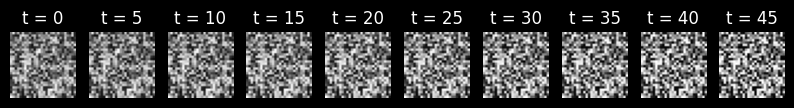

In [40]:
for epoch in range(epochs):
    for step, (x, _) in enumerate(tqdm(sample_loader)):
        optimizer.zero_grad()
        
        #* create random noise
        t = torch.randint(0, T, (batch_size,)).to(device)
        loss = get_loss(
            model, 
            x,
            t,
            Forward_pass,
            sqrt_alphas_cumpord,
            sqrt_one_minus_alphas_cumpord,
            device=device,
            torch_seed=42,
            )
        
        loss.backward()
        optimizer.step()
        
        if epoch % 1 == 0 and step == 0:
            print(f"Epoch: {epoch}, Step: {step}, Loss: {loss}")
            sample_plot_image(device)
            
        